In [2]:
import numpy as np
import xarray as xr
from scipy.optimize import curve_fit
from numba import jit
import pandas as pd
import glob
import datetime
# import xesmf as xe
import scipy.signal

In [3]:
import cartopy as cart
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as feature
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

In [4]:
header = '/data2/users/lch204ok/persistence/'
dir_41yr = header + '41yr/'
dir_oisst = dir_41yr + 'OISST/'
dir_era5 = dir_41yr + 'ERA5/'
dir_data = dir_41yr + 'data_availability/'
data_av = dir_data

## Get necessary dataset
- global MLD (climatology & linear trend)
- global MLD time series (linear fitted using above)
- global MLD montly time series (montly averaged)
- global power spectral density of sea surface temperature (SST) anomalies by year
- global memory timescale by year
- global analysed SST and SST anomalies (OISST)

In [5]:
mld_xr = xr.open_dataset(header + '1970-2018_MLD_1_degree_Sallee.nc')
mld_fit = xr.open_dataset(header + '1982-2022_fitted_MLD_Sallee.nc')
mld_monthly_fit = xr.open_dataset(header+"1982-2022_monthly_fitted_MLD_Sallee.nc")
ps_sst = xr.open_dataset(data_av+'1982-2022_annual_ps_sst.nc')
annual_tau = xr.open_dataarray(dir_data + '1982-2022_annual_thermal_memory.nc')
analysed_sst = xr.open_dataset(dir_data + '1982-2022_analysed_sst.nc')

In [17]:
rho_w = 1.025e3
c_wp = 3.996e3
day2sec = 60*60*24
freq_sec = (ps_sst.frequency/day2sec).data

In [18]:
climat_mld = mld_xr.climato_mld.data
climat_gamma = rho_w*c_wp*climat_mld
annual_omega_c = (1/annual_tau/day2sec).data
climat_omega_c = (1/annual_tau/day2sec).mean('time').data
climat_ssta_var = ps_sst.ps_ssta.mean('time').data

### Equation 1

$$
(\hat{T}_\omega')^2
= \left(\frac{\hat{F}_\omega}{C_0}\right)^2
  \frac{1}{\omega^2 + \omega_c^2},
$$

### get forcing $\hat{F}_{\omega}$ isolating target variable

# MLD fit (MLD sensitivity (contribution))

### laod MLD data (Sallee et al, 2020)

In [21]:
mld_fore = mld_fit.sel(time=slice('1982-01-01','1986-12-31')).mean('time')['mld'].data
mld_last_2021 = mld_fit.sel(time=slice('2017-01-01','2021-12-31')).mean('time')['mld'].data
mld_last_2022 = mld_fit.sel(time=slice('2018-01-01','2022-12-31')).mean('time')['mld'].data

define a function to calculate variance of SSTa using the analytic solution

### Equation 2

In [38]:
@jit(nopython=True)
def var_of_ssta(forcing_data,freq_data,mld_data,lambda_total_data):
    gamma = rho_w*c_wp*mld_data
    sst_var = forcing_data/gamma**2/(freq_data**2+(lambda_total_data/gamma)**2)
    return sst_var

We use forcing as non-white noise (loading invary forcing $F = F_a + F_o$)

In [39]:
forcing_var = xr.open_dataset(dir_data+'1982-2022_fitted_forcing.nc')
forcing_np = forcing_var['fit_climato'].data

loading $\lambda_{total} (=\lambda_a+\lambda_o$)

In [40]:
lambda_xr = xr.open_dataset(dir_data+'1982-2022_annual_heatflux_feedback.nc')

In [41]:
lambda_total = lambda_xr['lambda_sh'] + lambda_xr['lambda_lw'] + lambda_xr['lambda_lh'] + lambda_xr['lambda_o']
climat_lambda_total = lambda_total.mean('time')
climat_lambda_total_np = climat_lambda_total.data

every variable is invariant except for mld

In [42]:
sst_var_mld_fore = np.zeros([181,180,360])*np.nan
sst_var_mld_last_2021 = np.zeros([181,180,360])*np.nan
sst_var_mld_last_2022 = np.zeros([181,180,360])*np.nan
for lat_idx in range(180):
    for lon_idx in range(360):
        sst_var_mld_fore[:,lat_idx,lon_idx] = var_of_ssta(forcing_np[:,lat_idx,lon_idx],freq_sec,mld_fore[lat_idx,lon_idx],climat_lambda_total_np[lat_idx,lon_idx])
        sst_var_mld_last_2021[:,lat_idx,lon_idx] = var_of_ssta(forcing_np[:,lat_idx,lon_idx],freq_sec,mld_last_2021[lat_idx,lon_idx],climat_lambda_total_np[lat_idx,lon_idx])
        sst_var_mld_last_2022[:,lat_idx,lon_idx] = var_of_ssta(forcing_np[:,lat_idx,lon_idx],freq_sec,mld_last_2022[lat_idx,lon_idx],climat_lambda_total_np[lat_idx,lon_idx])

sample location (120,220)

1. MLD

In [43]:
mld_fore[130,-20]

49.546998197481464

In [44]:
print(mld_last_2021[130,-20])
print(mld_last_2022[130,-20])

56.58476568722972
56.785844758365386


2. Location

In [45]:
lat_sample = lambda_xr.lat[130].data
lon_sample = lambda_xr.lon[-20].data

In [46]:
lat_sample

array(40.5, dtype=float32)

In [47]:
lon_sample

array(340.5, dtype=float32)

3. $\lambda_{total}$

In [48]:
climat_lambda_total_np[130,-20]

214.57081774812633

In [49]:
sst_ps_fore_np = ps_sst.sel(time=slice('1982-01-01','1986-12-31')).mean('time')['ps_ssta'].data
sst_ps_last_np_2021 = ps_sst.sel(time=slice('2017-01-01','2021-12-31')).mean('time')['ps_ssta'].data
sst_ps_last_np_2022 = ps_sst.sel(time=slice('2017-01-01','2022-12-31')).mean('time')['ps_ssta'].data
climat_ssta_var = ps_sst.mean('time')['ps_ssta'].data

Text(0, 0.5, 'variance [$K^{2}$]')

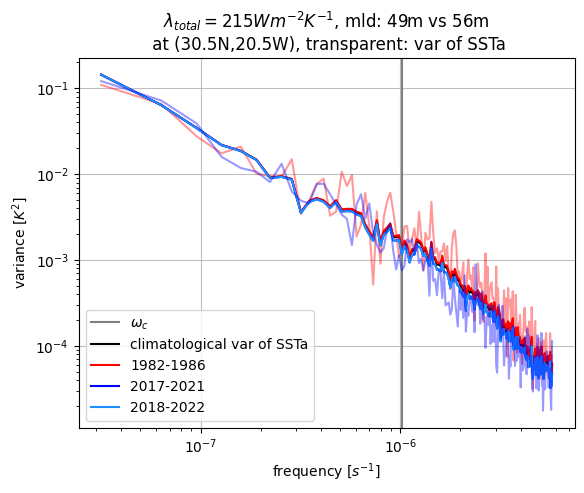

In [50]:
# plt.loglog(freq_sec,climat_ssta_var[:,100,200])
vline = climat_lambda_total_np[130,-20]/climat_gamma[130,-20]
plt.axvline(x = vline, color = 'gray', label = '$\omega_c$')
plt.loglog(freq_sec,climat_ssta_var[:,130,-20],'k',label='climatological var of SSTa')
plt.loglog(freq_sec,sst_var_mld_fore[:,130,-20],'r',label='1982-1986')
plt.loglog(freq_sec,sst_ps_fore_np[:,130,-20],'r',alpha=0.4)
plt.loglog(freq_sec,sst_var_mld_last_2021[:,130,-20],'b',label='2017-2021')
plt.loglog(freq_sec,sst_var_mld_last_2022[:,130,-20],'dodgerblue',label='2018-2022')
plt.loglog(freq_sec,sst_ps_last_np_2021[:,130,-20],'b',alpha=0.4)
plt.title('$\lambda_{total}=215 Wm^{-2}K^{-1}$, mld: 49m vs 56m \n at (30.5N,20.5W), transparent: var of SSTa')
plt.legend()
plt.grid(alpha=0.8)
plt.xlabel('frequency [$s^{-1}$]')
plt.ylabel('variance [$K^{2}$]')

In [51]:
sst_var_mld = xr.Dataset(
    data_vars = dict(
        fit_fore = (['frequency','lat','lon'],sst_var_mld_fore),
        fit_last_2021 = (['frequency','lat','lon'],sst_var_mld_last_2021),
        fit_last_2022 = (['frequency','lat','lon'],sst_var_mld_last_2022)
    ),
    coords = dict(
        frequency = ps_sst.frequency.data,
        lat = annual_tau.lat.data,
        lon = annual_tau.lon.data
    )
)

In [52]:
sst_var_mld.to_netcdf(dir_data + 'MLD_fit_ps_ssta.nc')

# $\lambda$ fit (damping sensitivity (contribution))

doing lambda_fit using Equation 2

In [53]:
lambda_total_fore = lambda_total.sel(time=slice('1982-01-01','1986-12-31')).mean('time').data
lambda_total_last_2021 = lambda_total.sel(time=slice('2017-01-01','2021-12-31')).mean('time').data
lambda_total_last_2022 = lambda_total.sel(time=slice('2018-01-01','2022-12-31')).mean('time').data

In [54]:
sst_var_lambda_fore = np.zeros([181,180,360])*np.nan
sst_var_lambda_last_2021 = np.zeros([181,180,360])*np.nan
sst_var_lambda_last_2022 = np.zeros([181,180,360])*np.nan
for lat_idx in range(180):
    for lon_idx in range(360):
        sst_var_lambda_fore[:,lat_idx,lon_idx] = var_of_ssta(forcing_np[:,lat_idx,lon_idx],freq_sec,climat_mld[lat_idx,lon_idx],lambda_total_fore[lat_idx,lon_idx])
        sst_var_lambda_last_2021[:,lat_idx,lon_idx] = var_of_ssta(forcing_np[:,lat_idx,lon_idx],freq_sec,climat_mld[lat_idx,lon_idx],lambda_total_last_2021[lat_idx,lon_idx])
        sst_var_lambda_last_2022[:,lat_idx,lon_idx] = var_of_ssta(forcing_np[:,lat_idx,lon_idx],freq_sec,climat_mld[lat_idx,lon_idx],lambda_total_last_2022[lat_idx,lon_idx])

In [55]:
print(lambda_total_fore[130,-20], lambda_total_last_2021[130,-20], lambda_total_last_2022[130,-20])

310.4127522465948 172.37175264003835 153.66576212370552


In [56]:
climat_mld[130,-20]

51.557788908838106

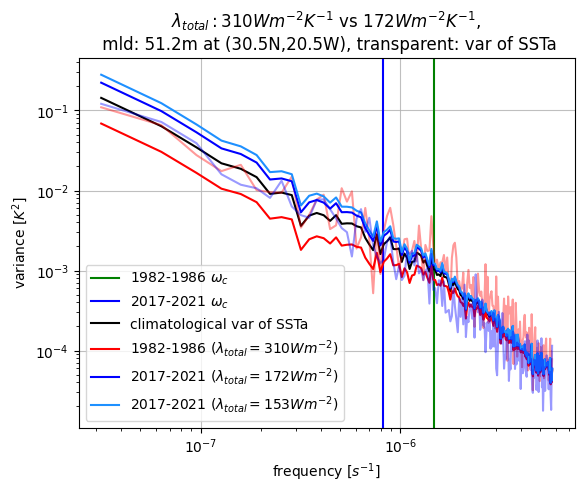

In [57]:
# plt.loglog(freq_sec,climat_ssta_var[:,100,200])
vline_fore = lambda_total_fore[130,-20]/climat_gamma[130,-20]
vline_last_2021 = lambda_total_last_2021[130,-20]/climat_gamma[130,-20]
plt.axvline(x = vline_fore, color = 'g', label = '1982-1986 ${\omega_c}$')
plt.axvline(x = vline_last_2021, color = 'b', label = '2017-2021 ${\omega_c}$')
plt.loglog(freq_sec,climat_ssta_var[:,130,-20],'k',label='climatological var of SSTa')
plt.loglog(freq_sec,sst_var_lambda_fore[:,130,-20],'r',label='1982-1986 ($\lambda_{total}=310 Wm^{-2}$)')
plt.loglog(freq_sec,sst_ps_fore_np[:,130,-20],'r',alpha=0.4)
plt.loglog(freq_sec,sst_var_lambda_last_2021[:,130,-20],'b',label='2017-2021 ($\lambda_{total}=172 Wm^{-2}$)')
plt.loglog(freq_sec,sst_var_lambda_last_2022[:,130,-20],'dodgerblue',label='2017-2021 ($\lambda_{total}=153 Wm^{-2}$)')
plt.loglog(freq_sec,sst_ps_last_np_2021[:,130,-20],'b',alpha=0.4)
plt.title('$\lambda_{total}: 310 Wm^{-2}K^{-1}$ vs $172 Wm^{-2}K^{-1}$, \n mld: 51.2m at (30.5N,20.5W), transparent: var of SSTa')
plt.grid(alpha=0.8)
plt.xlabel('frequency [$s^{-1}$]')
plt.ylabel('variance [$K^{2}$]')
plt.legend()

In [58]:
sst_var_lambda = xr.Dataset(
    data_vars = dict(
        fit_fore = (['frequency','lat','lon'],sst_var_lambda_fore),
        fit_last_2021 = (['frequency','lat','lon'],sst_var_lambda_last_2021),
        fit_last_2022 = (['frequency','lat','lon'],sst_var_lambda_last_2022)
    ),
    coords = dict(
        frequency = ps_sst.frequency.data,
        lat = annual_tau.lat.data,
        lon = annual_tau.lon.data
    )
)

In [75]:
sst_var_lambda.to_netcdf(dir_data + 'Lambda_fit_ps_ssta.nc')

# Forcing Fit (forcing sensitivity (contribution))

In [61]:
forcing_fore_np = forcing_var.fit_fore.data
forcing_last_np_2021 = forcing_var.fit_last_2021.data
forcing_last_np_2022 = forcing_var.fit_last_2022.data

In [62]:
# version_1: Climatological MLD, Damping coefficient
sst_var_forcing_fore = np.zeros([181,180,360])*np.nan
sst_var_forcing_last_2021 = np.zeros([181,180,360])*np.nan
sst_var_forcing_last_2022 = np.zeros([181,180,360])*np.nan
for lat_idx in range(180):
    for lon_idx in range(360):
        sst_var_forcing_fore[:,lat_idx,lon_idx] = var_of_ssta(forcing_fore_np[:,lat_idx,lon_idx],freq_sec,climat_mld[lat_idx,lon_idx],climat_lambda_total_np[lat_idx,lon_idx])
        sst_var_forcing_last_2021[:,lat_idx,lon_idx] = var_of_ssta(forcing_last_np_2021[:,lat_idx,lon_idx],freq_sec,climat_mld[lat_idx,lon_idx],climat_lambda_total_np[lat_idx,lon_idx])
        sst_var_forcing_last_2022[:,lat_idx,lon_idx] = var_of_ssta(forcing_last_np_2022[:,lat_idx,lon_idx],freq_sec,climat_mld[lat_idx,lon_idx],climat_lambda_total_np[lat_idx,lon_idx])

In [63]:
# version_2: Varying MLD, Damping coefficient
sst_var_forcing_fore = np.zeros([181,180,360])*np.nan
sst_var_forcing_last_2021 = np.zeros([181,180,360])*np.nan
sst_var_forcing_last_2022 = np.zeros([181,180,360])*np.nan
for lat_idx in range(180):
    for lon_idx in range(360):
        sst_var_forcing_fore[:,lat_idx,lon_idx] = var_of_ssta(forcing_fore_np[:,lat_idx,lon_idx],freq_sec,mld_fore[lat_idx,lon_idx],lambda_total_fore[lat_idx,lon_idx])
        sst_var_forcing_last_2021[:,lat_idx,lon_idx] = var_of_ssta(forcing_last_np_2021[:,lat_idx,lon_idx],freq_sec,mld_last_2021[lat_idx,lon_idx],lambda_total_last_2021[lat_idx,lon_idx])
        sst_var_forcing_last_2022[:,lat_idx,lon_idx] = var_of_ssta(forcing_last_np_2022[:,lat_idx,lon_idx],freq_sec,mld_last_2022[lat_idx,lon_idx],lambda_total_last_2022[lat_idx,lon_idx])

In [64]:
sst_var_forcing = xr.Dataset(
    data_vars = dict(
        fit_fore = (['frequency','lat','lon'],sst_var_forcing_fore),
        fit_last_2021 = (['frequency','lat','lon'],sst_var_forcing_last_2021),
        fit_last_2022 = (['frequency','lat','lon'],sst_var_forcing_last_2022)
    ),
    coords = dict(
        frequency = ps_sst.frequency.data,
        lat = annual_tau.lat.data,
        lon = annual_tau.lon.data
    )
)

In [81]:
sst_var_forcing.to_netcdf(dir_data + 'Forcing_fit_ps_ssta.nc')